# 社交网络分析

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from db_connection import fetch_data
import matplotlib.cm as cm
import warnings
import matplotlib.colors as mcolors

# 忽略警告
warnings.filterwarnings("ignore", category=UserWarning, module="networkx")

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 解决中文显示问题
plt.rcParams["axes.unicode_minus"] = False


2025-03-27 17:54:00,507 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2025-03-27 17:54:00,510 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 17:54:00,854 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2025-03-27 17:54:00,856 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 17:54:01,208 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2025-03-27 17:54:01,211 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 17:54:01,504 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-27 17:54:01,505 INFO sqlalchemy.engine.Engine DESCRIBE `chat_app`.`SELECT * FROM users`
2025-03-27 17:54:01,506 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 17:54:01,924 INFO sqlalchemy.engine.Engine SELECT * FROM users
2025-03-27 17:54:01,925 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 17:54:01,999 INFO sqlalchemy.engine.Engine ROLLBACK
    id    username                                           password
0    1              $2a$10$374GRnyxOykh7jvoLSsc..Gz9isJrIeh3h

## 🔹 社交关系网络图

2025-03-27 17:54:19,628 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-27 17:54:19,630 INFO sqlalchemy.engine.Engine DESCRIBE `chat_app`.`SELECT user_id, friend_id FROM friends`
2025-03-27 17:54:19,631 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 17:54:20,117 INFO sqlalchemy.engine.Engine SELECT user_id, friend_id FROM friends
2025-03-27 17:54:20,119 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 17:54:20,238 INFO sqlalchemy.engine.Engine ROLLBACK


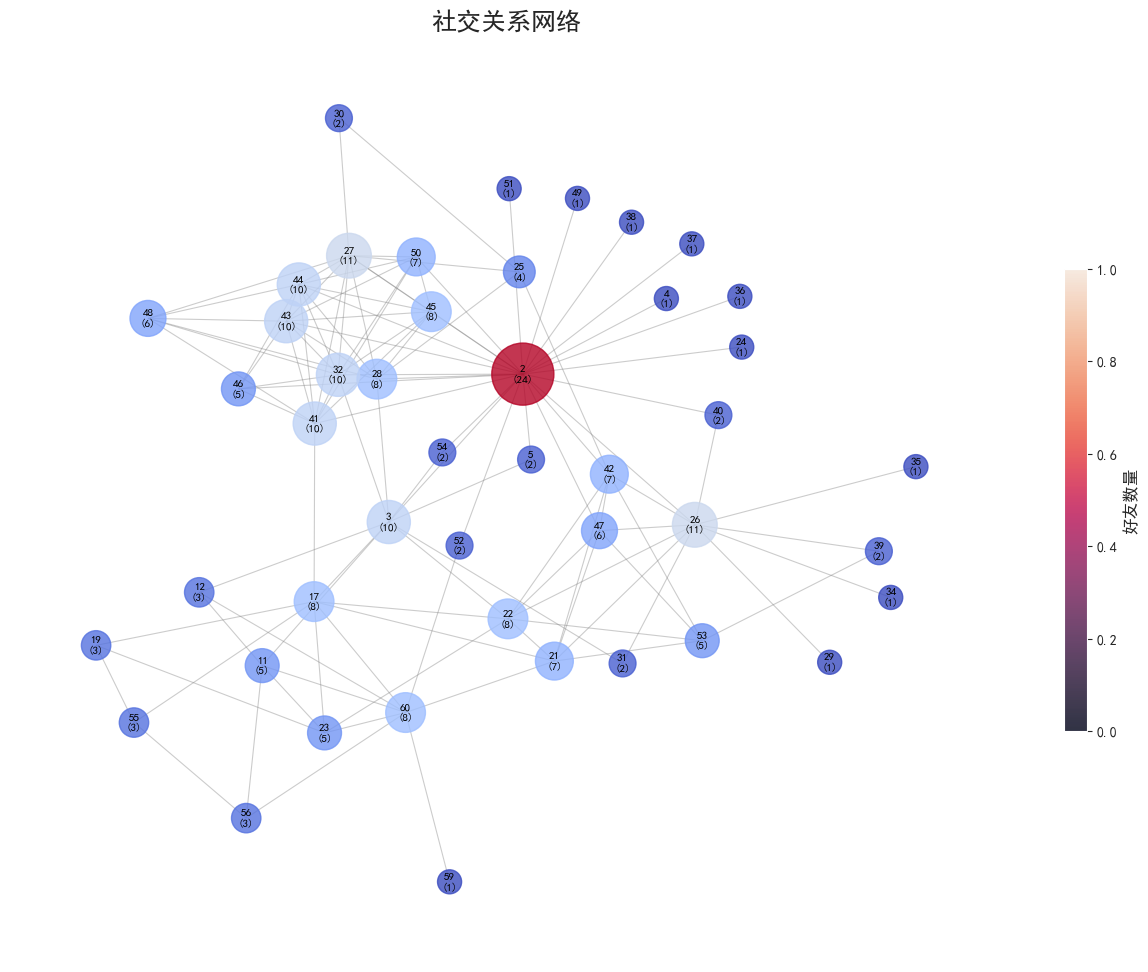

In [6]:
# 获取好友关系数据
query = "SELECT user_id, friend_id FROM friends"
df_friends = fetch_data(query)

# 构建 NetworkX 图
G = nx.Graph()
for _, row in df_friends.iterrows():
    G.add_edge(row["user_id"], row["friend_id"])

# 计算节点的度（好友数量）
degrees = dict(G.degree())

# 选择更均匀的布局
pos = nx.kamada_kawai_layout(G)

# 颜色映射（根据好友数调整颜色深度）
norm = mcolors.Normalize(vmin=min(degrees.values()), vmax=max(degrees.values()))
node_colors = [cm.coolwarm(norm(degrees[node])) for node in G.nodes()]
node_sizes = [np.interp(degrees[node], (min(degrees.values()), max(degrees.values())), (300, 2000)) for node in G.nodes()]

fig, ax = plt.subplots(figsize=(16, 12))  # 增大画布减少重叠

# 绘制边（透明度降低，突出节点）
nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.4, width=0.8, ax=ax)

# 绘制节点（大小和颜色都反映好友数量）
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=cm.viridis, alpha=0.8, ax=ax)


# 生成标签（显示 ID + 好友数量）
labels = {node: f"{node}\n({degrees[node]})" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color="black", font_weight="bold", ax=ax)

# 添加颜色条，表示好友数量
cbar = fig.colorbar(nodes, ax=ax, shrink=0.5)
cbar.set_label("好友数量", fontsize=12)

# 设置标题
plt.title("社交关系网络", fontsize=18, weight="bold")
plt.axis("off")
plt.show()


## 🔹 消息互动网络图

2025-03-27 21:05:52,153 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-27 21:05:52,154 INFO sqlalchemy.engine.Engine DESCRIBE `chat_app`.`SELECT sender_id, receiver_id, COUNT(*) as weight FROM messages GROUP BY sender_id, receiver_id`
2025-03-27 21:05:52,154 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 21:05:52,197 INFO sqlalchemy.engine.Engine SELECT sender_id, receiver_id, COUNT(*) as weight FROM messages GROUP BY sender_id, receiver_id
2025-03-27 21:05:52,198 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 21:05:52,232 INFO sqlalchemy.engine.Engine ROLLBACK


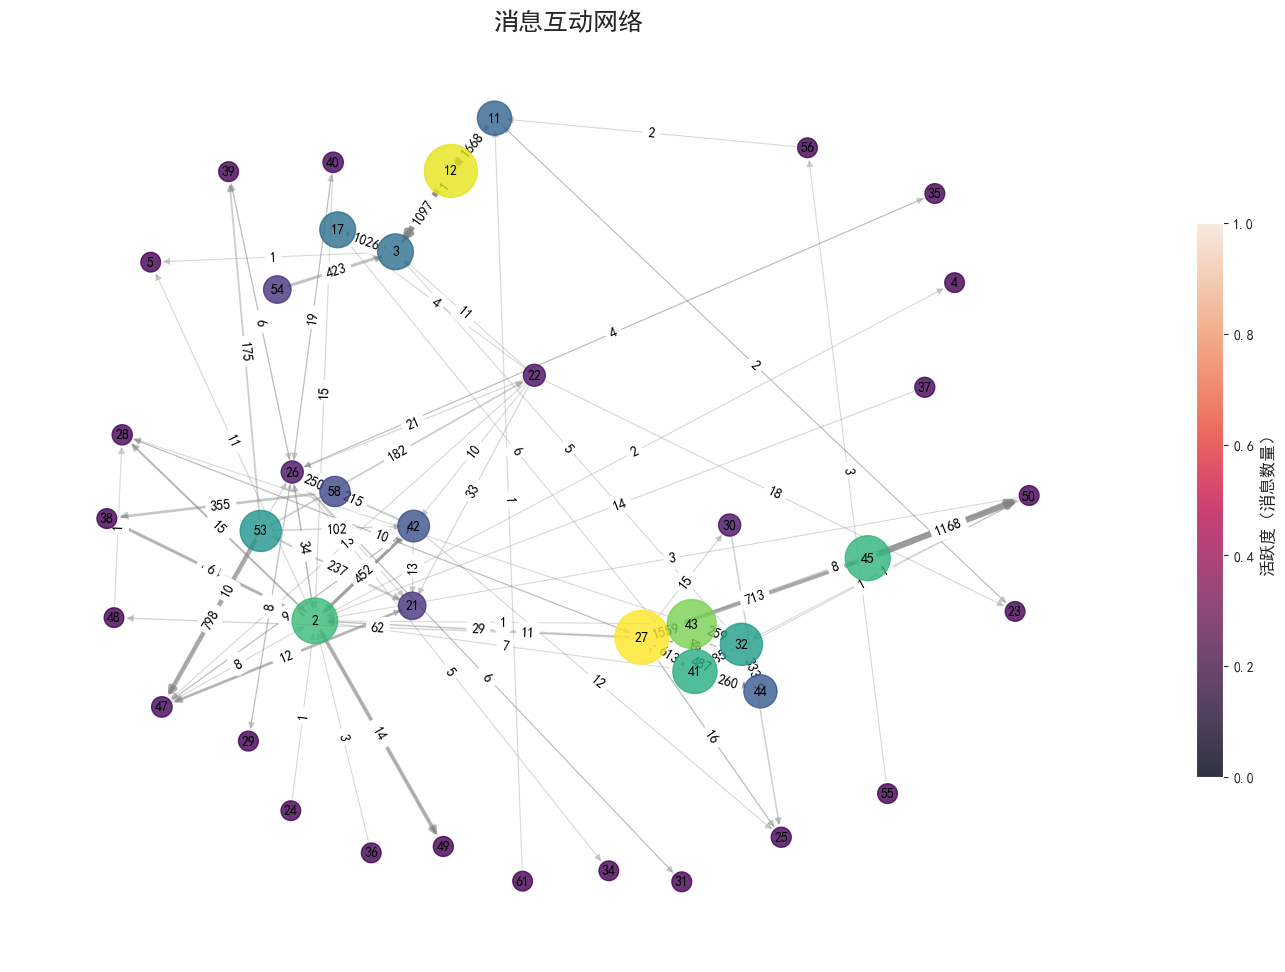

In [9]:
# 获取消息互动数据
query = "SELECT sender_id, receiver_id, COUNT(*) as weight FROM messages GROUP BY sender_id, receiver_id"
df_messages = fetch_data(query)

# 构建加权图
G_msg = nx.DiGraph()
for _, row in df_messages.iterrows():
    G_msg.add_edge(row["sender_id"], row["receiver_id"], weight=row["weight"])

# 计算节点的活跃度（出度 + 入度）
node_activity = {node: sum(d["weight"] for _, _, d in G_msg.edges(node, data=True)) for node in G_msg.nodes()}

# 归一化节点大小
min_size, max_size = 200, 1500  # 调大节点大小范围
sizes = np.array(list(node_activity.values()))
sizes = np.interp(sizes, (sizes.min(), sizes.max()), (min_size, max_size))

# 选择合适的布局，让节点更分散
pos = nx.spring_layout(G_msg, k=3.0, scale=10, seed=42)  # 让布局更开阔

# 获取边的权重，并归一化宽度
edges, weights = zip(*nx.get_edge_attributes(G_msg, "weight").items())
edge_width = np.interp(weights, (min(weights), max(weights)), (0.8, 6))  # 让边的宽度更明显
edge_alpha = np.interp(weights, (min(weights), max(weights)), (0.3, 1.0))  # 控制透明度

# 颜色映射（让节点颜色根据活跃度变化）
norm = mcolors.Normalize(vmin=min(node_activity.values()), vmax=max(node_activity.values()))
node_colors = [cm.viridis(norm(node_activity[n])) for n in G_msg.nodes()]

fig, ax = plt.subplots(figsize=(18, 12))  # 显式创建更大的画布

# 绘制边（半透明以减少视觉干扰）
nx.draw_networkx_edges(G_msg, pos, alpha=edge_alpha, width=edge_width, edge_color="gray", ax=ax)

# 绘制节点（颜色根据活跃度，大小适中）
nodes = nx.draw_networkx_nodes(G_msg, pos, node_size=sizes, node_color=node_colors, cmap=cm.viridis, alpha=0.8, ax=ax)

# 绘制标签（增大字体，提高可读性）
nx.draw_networkx_labels(G_msg, pos, font_size=10, font_color="black", font_weight="bold", ax=ax)

# 显示边的权重（稍微增大字体）
edge_labels = {(u, v): d["weight"] for u, v, d in G_msg.edges(data=True)}
nx.draw_networkx_edge_labels(G_msg, pos, edge_labels=edge_labels, font_size=10, ax=ax)

# 添加颜色条，表示活跃度
cbar = fig.colorbar(nodes, ax=ax, shrink=0.6)
cbar.set_label("活跃度（消息数量）", fontsize=12)

# 设置标题
plt.title("消息互动网络", fontsize=18)
plt.axis("off")
plt.show()


## 🔹 消息时间序列分析

2025-03-27 17:54:08,555 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-03-27 17:54:08,556 INFO sqlalchemy.engine.Engine DESCRIBE `chat_app`.`SELECT timestamp FROM messages`
2025-03-27 17:54:08,557 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 17:54:08,895 INFO sqlalchemy.engine.Engine SELECT timestamp FROM messages
2025-03-27 17:54:08,896 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-03-27 17:54:12,286 INFO sqlalchemy.engine.Engine ROLLBACK


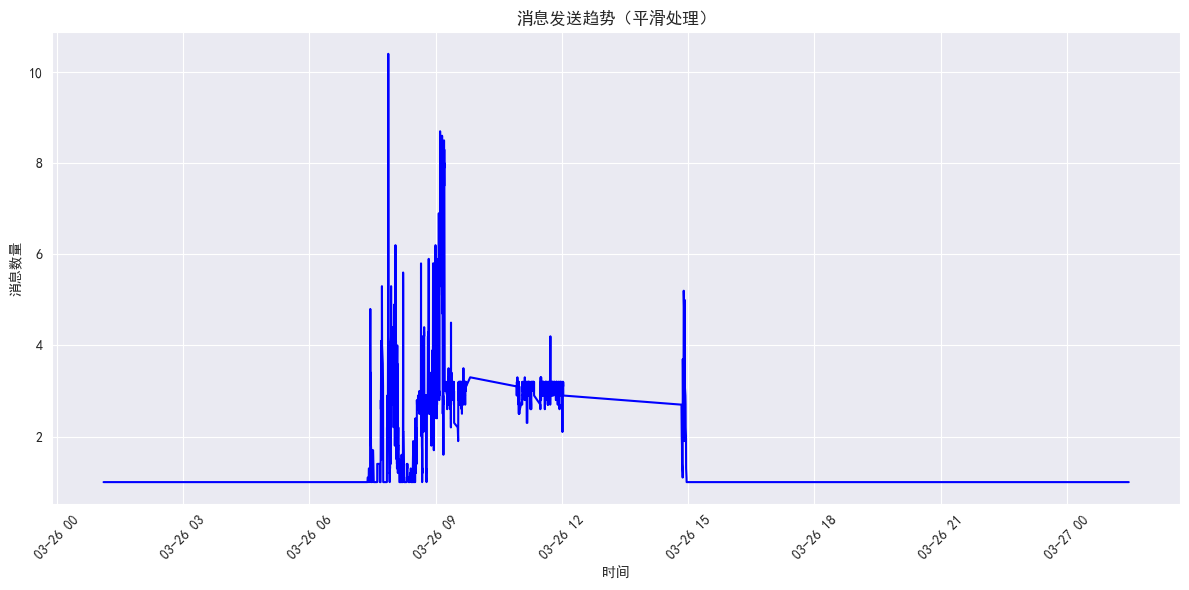

In [4]:
# 获取消息数据
query = "SELECT timestamp FROM messages"
df_time = fetch_data(query)

# 处理时间数据
df_time["timestamp"] = pd.to_datetime(df_time["timestamp"])

# 按时间戳分组，统计每个时间点的消息数量
msg_count = df_time.groupby(df_time["timestamp"]).size()

# 平滑处理：使用滚动平均
window_size = 10  # 设置窗口大小，可以根据需要调整
msg_count_smoothed = msg_count.rolling(window=window_size, min_periods=1).mean()

# 绘制消息发送趋势（平滑处理）
plt.figure(figsize=(12, 6))
sns.lineplot(x=msg_count.index, y=msg_count_smoothed,color="b")
plt.xlabel("时间")
plt.ylabel("消息数量")
plt.title("消息发送趋势（平滑处理）")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔹 好友度分布

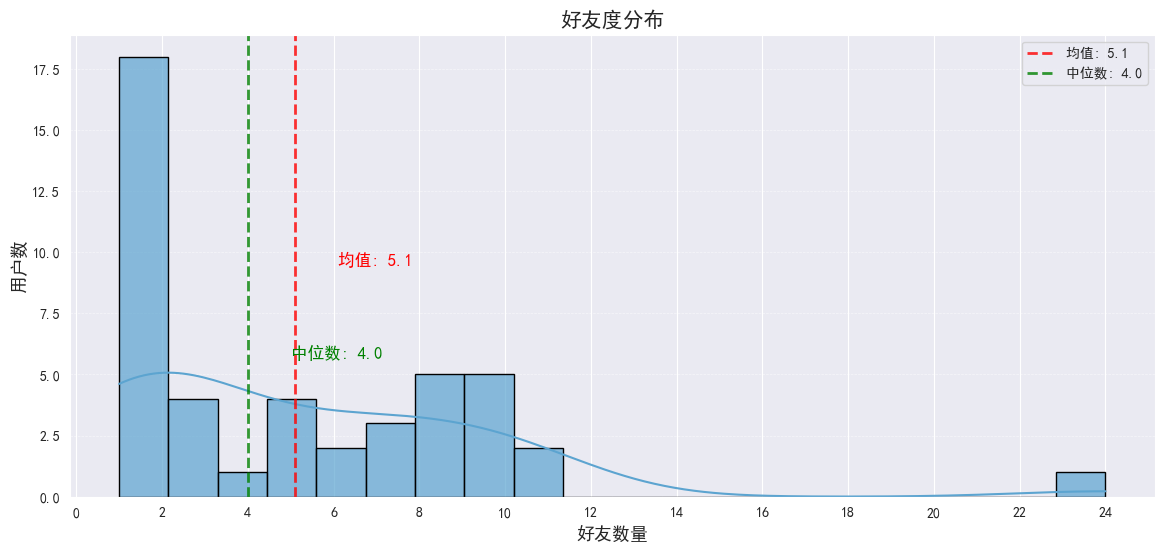

In [5]:
# 计算每个用户的好友数量
friend_counts = df_friends["user_id"].value_counts()

# 计算均值和中位数
mean_friends = friend_counts.mean()
median_friends = friend_counts.median()

# 创建画布
plt.figure(figsize=(14, 6))  # 宽一些，避免数据重叠

# 颜色渐变
sns.histplot(
    friend_counts, bins=20, kde=True,
    color=sns.color_palette("Blues", 10)[5], edgecolor="black", alpha=0.7
)

# 添加均值和中位数标记（虚线+文字）
plt.axvline(mean_friends, color="red", linestyle="--", linewidth=2, alpha=0.8, label=f"均值: {mean_friends:.1f}")
plt.axvline(median_friends, color="green", linestyle="--", linewidth=2, alpha=0.8, label=f"中位数: {median_friends:.1f}")

# 添加文本标注
plt.text(mean_friends + 1, plt.ylim()[1] * 0.5, f"均值: {mean_friends:.1f}", color="red", fontsize=12, weight="bold")
plt.text(median_friends + 1, plt.ylim()[1] * 0.3, f"中位数: {median_friends:.1f}", color="green", fontsize=12, weight="bold")


# 标题 & 轴标签
plt.xlabel("好友数量", fontsize=13)
plt.ylabel("用户数", fontsize=13)
plt.title("好友度分布", fontsize=15, weight="bold")

# 只显示 y 轴的网格，增强对比度
plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

# 调整 x 轴刻度，使其更直观
plt.xticks(np.arange(0, friend_counts.max() + 1, step=max(friend_counts) // 10))

# 显示图例
plt.legend()

# 显示图像
plt.show()
